# how many novel lncRNAs are quantified?

evidence that the new lncRNAs are expressed/quantifiable in v10 vs v11.

v10 used gencode 46 with 19000 lncRNAs, v11 uses gencode 47 with 35000 lncRNAs

In [104]:
import pandas as pd
import seaborn as sns
import pyranges as pr
import numpy as np
import matplotlib.pyplot as plt
import upsetplot as up
from matplotlib.colors import hex2color
from scipy.stats.kde import gaussian_kde
from matplotlib.colors import LogNorm
from scipy import stats
import os
import matplotlib.patches as patches


from tqdm.notebook import tqdm

tqdm.pandas()

/local/scratch/klawren/slrmtmp.47907055/ipykernel_10993/1493566646.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [2]:
gene_type_order = ['lncRNA', 'protein_coding', 'pseudogene', 'other_noncoding_RNA']

gene_type_pal = {'lncRNA':'#b70657',
                 'protein_coding':'#215B30',
                 'other_noncoding_RNA':'#6A5ACD',
                 'pseudogene':'#005BBF'}

gene_type_order_highlight = ['CLS_lncRNA', 'other_lncRNA', 'protein_coding', 'pseudogene', 'other_noncoding_RNA']

gene_type_pal_highlight = {'CLS_lncRNA':'#fb83ba',
                            'other_lncRNA':'#b70657',
                            'protein_coding':'#215B30',
                            'other_noncoding_RNA':'#6A5ACD',
                            'pseudogene':'#005BBF'}

In [3]:
gencode_v39_path = "/home/klawren/oak/gtex/data/other_references/gencode.v39.genes.gtf"
gencode_v47_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.genes.gtf"
full_gencode_v39_path = "/home/klawren/oak/gtex/data/other_references/gencode.v39.annotation.gtf"
full_gencode_v47_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.annotation.gtf"

v10_quantificaiton_path = "/home/klawren/oak/gtex/data/other_references/v10/gene_tpm_v10_brain_caudate_basal_ganglia.gct.gz"
v11_quantificaiton_dir = "/home/klawren/oak/gtex/output/caudate_analysis"

### comparison of gencode annotations

In [4]:
# load in gencode for lncRNA annotations
gencode_v47=pr.read_gtf(gencode_v47_path).as_df()
gencode_v39=pr.read_gtf(gencode_v39_path).as_df()

In [5]:
full_gencode_v47=pr.read_gtf(full_gencode_v47_path).as_df()
full_gencode_v39=pr.read_gtf(full_gencode_v39_path).as_df()

In [6]:
gencode_v47['gene_id_stable'] = gencode_v47['gene_id'].str.split('.').str[0]
gencode_v39['gene_id_stable'] = gencode_v39['gene_id'].str.split('.').str[0]
full_gencode_v39['gene_id_stable'] = full_gencode_v39['gene_id'].str.split('.').str[0]
full_gencode_v47['gene_id_stable'] = full_gencode_v47['gene_id'].str.split('.').str[0]

In [19]:
# par y genes are collapsed into one stable gene id
len(gencode_v39[gencode_v39['Feature'] == 'gene'][gencode_v39[gencode_v39['Feature'] == 'gene'].duplicated('gene_id_stable')])


45

In [20]:
# harmonize annotation categories as in https://www.gencodegenes.org/pages/biotypes.html
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type'].isin(['3prime_overlapping_ncRNA', 'antisense', 'bidirectional_promoter_lncRNA', 'lincRNA', 'macro_lncRNA', 'non_coding', 'processed_transcript', 'sense_intronic','sense_overlapping']), 'lncRNA', gencode_v39['gene_type'])
gencode_v39['gene_type_harmonized'] = np.where(gencode_v39['gene_type_harmonized'].isin(['vaultRNA']), 'vault_RNA', gencode_v39['gene_type_harmonized'])

full_gencode_v39['gene_type_harmonized'] = np.where(full_gencode_v39['gene_type'].isin(['3prime_overlapping_ncRNA', 'antisense', 'bidirectional_promoter_lncRNA', 'lincRNA', 'macro_lncRNA', 'non_coding', 'processed_transcript', 'sense_intronic','sense_overlapping']), 'lncRNA', full_gencode_v39['gene_type'])
full_gencode_v39['gene_type_harmonized'] = np.where(full_gencode_v39['gene_type_harmonized'].isin(['vaultRNA']), 'vault_RNA', full_gencode_v39['gene_type_harmonized'])

In [21]:
gene_type_counts = pd.DataFrame({'v47':full_gencode_v47[full_gencode_v47['Feature'] == 'gene'].groupby('gene_type').size(), 'v39':full_gencode_v39[full_gencode_v39['Feature'] == 'gene'].groupby('gene_type_harmonized').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47907055/ipykernel_10993/3796981686.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


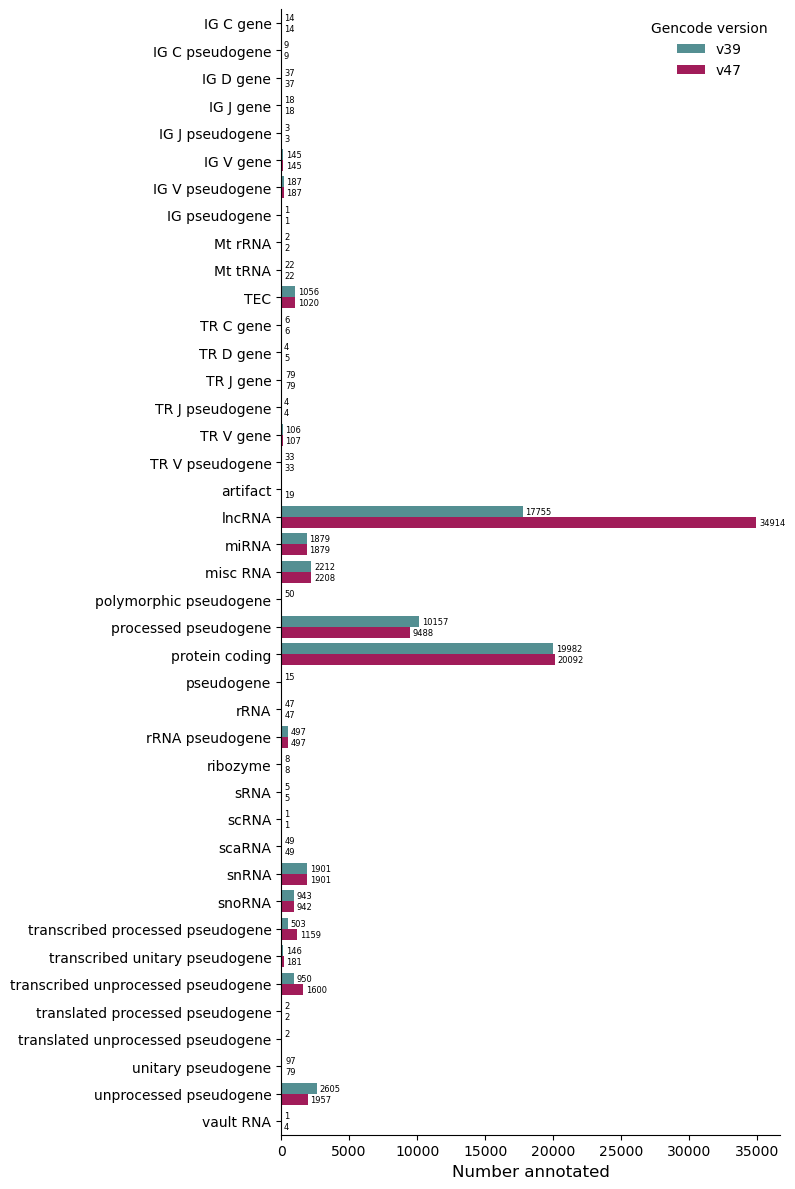

In [22]:
fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=['#4a989c', '#b70657'])

#ax.set_xscale('log')

ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")

plt.tight_layout() 
plt.show()

In [99]:
# group some categories 
def group_gene_type(gencode_df):
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_rRNA',
                                                                                            'Mt_tRNA',
                                                                                            'miRNA',
                                                                                            'misc_RNA',
                                                                                            'rRNA',
                                                                                            'scRNA',
                                                                                            'snRNA',
                                                                                            'snoRNA',
                                                                                            'ribozyme',
                                                                                            'sRNA',
                                                                                            'scaRNA',
                                                                                            'vault_RNA']), 'other_noncoding_RNA', gencode_df['gene_type_harmonized'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['Mt_tRNA_pseudogene',
                                                                                            'tRNA_pseudogene',
                                                                                            'snoRNA_pseudogene',
                                                                                            'snRNA_pseudogene',
                                                                                            'scRNA_pseudogene',
                                                                                            'rRNA_pseudogene',
                                                                                            'misc_RNA_pseudogene',
                                                                                            'miRNA_pseudogene']), 'pseudogene', gencode_df['gene_type_grouped'])
    

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_grouped'].isin(['noncoding_RNA_pseudogene']),'pseudogene', gencode_df['gene_type_grouped'])

    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['transcribed_processed_pseudogene',
                                                                                            'transcribed_unprocessed_pseudogene',
                                                                                            'transcribed_unitary_pseudogene',
                                                                                            'translated_processed_pseudogene',
                                                                                            'translated_unprocessed_pseudogene',
                                                                                            'unitary_pseudogene',
                                                                                            'unprocessed_pseudogene',
                                                                                            'pseudogene',
                                                                                            'polymorphic_pseudogene',
                                                                                            'processed_pseudogene',
                                                                                            'IG_C_pseudogene', 
                                                                                            'IG_J_pseudogene', 
                                                                                            'IG_V_pseudogene', 
                                                                                            'IG_pseudogene',
                                                                                            'TR_V_pseudogene',
                                                                                            'TR_J_pseudogene']), 'pseudogene', gencode_df['gene_type_grouped'])
    
    gencode_df['gene_type_grouped'] = np.where(gencode_df['gene_type_harmonized'].isin(['protein_coding', 
                                                                                        'TEC',
                                                                                        'IG_C_gene', 
                                                                                        'IG_D_gene', 
                                                                                        'IG_J_gene',
                                                                                        'IG_V_gene', 
                                                                                        'TR_C_gene',
                                                                                        'TR_J_gene',
                                                                                        'TR_V_gene',
                                                                                        'TR_D_gene']), 'protein_coding', gencode_df['gene_type_grouped'])


In [100]:
full_gencode_v47['gene_type_harmonized'] = full_gencode_v47['gene_type']
group_gene_type(full_gencode_v47)
group_gene_type(full_gencode_v39)

gencode_v47['gene_type_harmonized'] = gencode_v47['gene_type']
group_gene_type(gencode_v47)
group_gene_type(gencode_v39)

/local/scratch/klawren/slrmtmp.47907055/ipykernel_10993/924539402.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


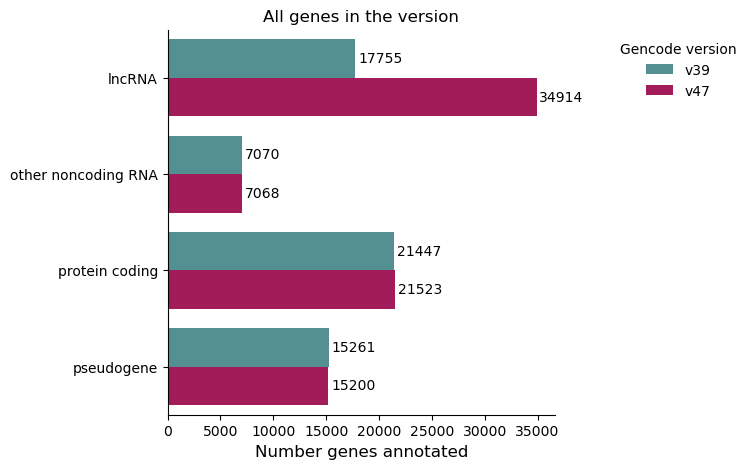

In [101]:
gene_type_counts = pd.DataFrame({'v47':full_gencode_v47[full_gencode_v47['Feature'] == 'gene'].groupby('gene_type_grouped').agg({'gene_id':'nunique'})['gene_id'], 'v39':full_gencode_v39[full_gencode_v39['Feature'] == 'gene'].groupby('gene_type_grouped').agg({'gene_id':'nunique'})['gene_id']}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.iloc[1:].melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=['#4a989c', '#b70657'])

ax.set_title('All genes in the version')

ax.set_xlabel('Number genes annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=10)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gencode version")
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.5, 1))

plt.show()

In [102]:
print('{} gencode v47 aren\'t in gencode v39'.format(sum(~gencode_v47[gencode_v47['Feature'] == 'gene']['gene_id_stable'].isin(gencode_v39['gene_id_stable']))))
print('{} gencode v39 aren\'t in gencode v47'.format(sum(~gencode_v39[gencode_v39['Feature'] == 'gene']['gene_id_stable'].isin(gencode_v47['gene_id_stable']))))

18154 gencode v47 aren't in gencode v39
2518 gencode v39 aren't in gencode v47


In [29]:
gene_type_counts = pd.DataFrame({'v47':gencode_v47[gencode_v47['Feature'] == 'gene'][~gencode_v47[gencode_v47['Feature'] == 'gene']['gene_id_stable'].isin(gencode_v39['gene_id_stable'])].groupby('gene_type_grouped').size(), 'v39':gencode_v39[gencode_v39['Feature'] == 'gene'][~gencode_v39[gencode_v39['Feature'] == 'gene']['gene_id_stable'].isin(gencode_v47['gene_id_stable'])].groupby('gene_type_grouped').size()}).reset_index(names='gene_type')
gene_type_melt = gene_type_counts.melt(id_vars=['gene_type'], value_vars=['v47', 'v39'], value_name='count', var_name='version')

/local/scratch/klawren/slrmtmp.47907055/ipykernel_10993/3799024315.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


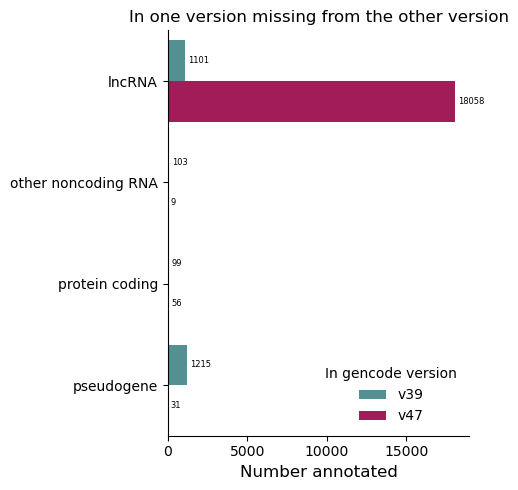

In [31]:
fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(gene_type_melt, y='gene_type', hue='version', x='count', hue_order=['v39', 'v47'], ax=ax, palette=[ '#4a989c', '#b70657'])

ax.set_title('In one version missing from the other version')
ax.set_xlabel('Number annotated', fontsize=12)
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=6)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

# legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("In gencode version")

plt.tight_layout() 
plt.show()

### genes lost in collapse
* same in full and collapse
* location chnage in full vs collapse
* not in collapse

each of those 

In [39]:
full_gencode_v39_gene = full_gencode_v39[full_gencode_v39['Feature']=='gene']
full_gencode_v47_gene = full_gencode_v47[full_gencode_v47['Feature']=='gene']

gencode_v39_gene = gencode_v39[gencode_v39['Feature']=='gene']
gencode_v47_gene = gencode_v47[gencode_v47['Feature']=='gene']

In [40]:
gencode_v39_merged = pd.merge(gencode_v39_gene[['Chromosome', 'Start', 'End' ,'gene_id', 'gene_id_stable']], full_gencode_v39_gene[['Chromosome', 'Start', 'End' , 'gene_id_stable', 'gene_id', 'gene_type_grouped']], on='gene_id_stable', suffixes=['_collapsed', '_full'], how='outer')
gencode_v39_merged['collapsed_location_match'] = (gencode_v39_merged['Start_collapsed'] == gencode_v39_merged['Start_full']) & (gencode_v39_merged['End_collapsed'] == gencode_v39_merged['End_full'])

gencode_v47_merged = pd.merge(gencode_v47_gene[['Chromosome', 'Start', 'End' ,'gene_id', 'gene_id_stable']], full_gencode_v47_gene[['Chromosome', 'Start', 'End' ,'gene_id_stable', 'gene_id', 'gene_type_grouped']], on='gene_id_stable', suffixes=['_collapsed', '_full'], how='outer')
gencode_v47_merged['collapsed_location_match'] = (gencode_v47_merged['Start_collapsed'] == gencode_v47_merged['Start_full']) & (gencode_v47_merged['End_collapsed'] == gencode_v47_merged['End_full'])

In [72]:
gencode_merged = pd.merge(gencode_v47_merged, gencode_v39_merged.drop_duplicates('gene_id_stable'), on=['gene_id_stable'], suffixes=['_v47', '_v39'], how='outer')
gencode_merged['gene_type_grouped'] = np.where(gencode_merged['gene_type_grouped_v47'].isna(), gencode_merged['gene_type_grouped_v39'], gencode_merged['gene_type_grouped_v47'])

gencode_merged['in_v47_full'] = ~(gencode_merged['gene_id_full_v47'].isna())
gencode_merged['in_v47_collapsed'] = ~(gencode_merged['gene_id_collapsed_v47'].isna())
gencode_merged['in_v39_full'] = ~(gencode_merged['gene_id_full_v39'].isna())
gencode_merged['in_v39_collapsed'] = ~(gencode_merged['gene_id_collapsed_v39'].isna())


In [77]:
gencode_merged['gene_type_grouped_highlight'] = gencode_merged['gene_type_grouped']
gencode_merged.loc[~(gencode_merged['in_v39_full'])&(gencode_merged['gene_type_grouped_highlight']=='lncRNA'),'gene_type_grouped_highlight'] = 'CLS_lncRNA'
gencode_merged.loc[gencode_merged['gene_type_grouped_highlight'] =='lncRNA','gene_type_grouped_highlight'] = 'other_lncRNA'
gencode_merged['gene_type_grouped_highlight'].value_counts()


gene_type_grouped_highlight
protein_coding         21579
CLS_lncRNA             18307
other_lncRNA           17747
pseudogene             15228
other_noncoding_RNA     7070
artifact                  19
Name: count, dtype: int64

In [90]:
len(gencode_merged)

79950

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


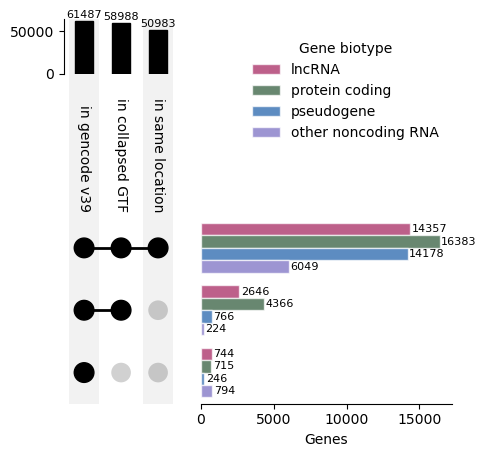

In [78]:
collapse_upset_v39 = up.from_indicators(gencode_merged[gencode_merged['in_v39_full']][['in_v39_full','in_v39_collapsed', 'collapsed_location_match_v39']], data=gencode_merged[gencode_merged['in_v39_full']]['gene_type_grouped'])
collapse_upset_v39.index.set_names(['in gencode v39', 'in collapsed GTF', 'in same location'], inplace=True)
collapse_upset_v39 = pd.DataFrame(collapse_upset_v39)
collapse_upset_categories = collapse_upset_v39.index.value_counts().index
collapse_upset_v39['idx_loc'] = np.where(collapse_upset_v39.index==collapse_upset_categories[0], 0, 
                                    np.where(collapse_upset_v39.index==collapse_upset_categories[1], 1, 2))

fig = plt.figure(figsize=(5, 5))
upset = up.UpSet(collapse_upset_v39, show_counts=False, subset_size='count', intersection_plot_elements=6, totals_plot_elements=1, orientation='vertical', element_size=None)
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())

totals_ax = plot_result['totals']
totals_ax.grid(False)
# add numbers to plot
for container in totals_ax.containers:
    totals_ax.bar_label(container, padding=1, fontsize=8,)

bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(collapse_upset_v39, y='idx_loc', hue='gene_type_grouped',ax=bar_ax, palette=gene_type_pal, hue_order=gene_type_order, alpha=.7, edgecolor='white')
bar_ax.set_xlabel('Genes')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=1, fontsize=8,)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1, 2), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


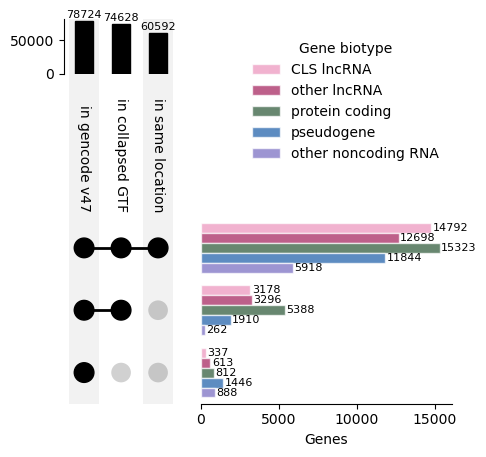

In [79]:
collapse_upset_v47 = up.from_indicators(gencode_merged[gencode_merged['in_v47_full']][['in_v47_full','in_v47_collapsed', 'collapsed_location_match_v47']], data=gencode_merged[gencode_merged['in_v47_full']]['gene_type_grouped_highlight'])
collapse_upset_v47.index.set_names(['in gencode v47', 'in collapsed GTF', 'in same location'], inplace=True)
collapse_upset_v47 = pd.DataFrame(collapse_upset_v47)
collapse_upset_categories = collapse_upset_v47.index.value_counts().index
collapse_upset_v47['idx_loc'] = np.where(collapse_upset_v47.index==collapse_upset_categories[0], 0, 
                                    np.where(collapse_upset_v47.index==collapse_upset_categories[1], 1, 2))

fig = plt.figure(figsize=(5, 5))
upset = up.UpSet(collapse_upset_v47, show_counts=False, subset_size='count', intersection_plot_elements=6, totals_plot_elements=1, orientation='vertical', element_size=None)
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())

totals_ax = plot_result['totals']
totals_ax.grid(False)
# add numbers to plot
for container in totals_ax.containers:
    totals_ax.bar_label(container, padding=1, fontsize=8,)

bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(collapse_upset_v47, y='idx_loc', hue='gene_type_grouped_highlight',ax=bar_ax, palette=gene_type_pal_highlight, hue_order=gene_type_order_highlight, alpha=.7, edgecolor='white')
bar_ax.set_xlabel('Genes')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=1, fontsize=8,)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1, 2), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

In [80]:
collapse_upset = up.from_indicators(gencode_merged[['in_v47_full', 'in_v47_collapsed', 'in_v39_full','in_v39_collapsed']], data=gencode_merged['gene_type_grouped_highlight'])

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


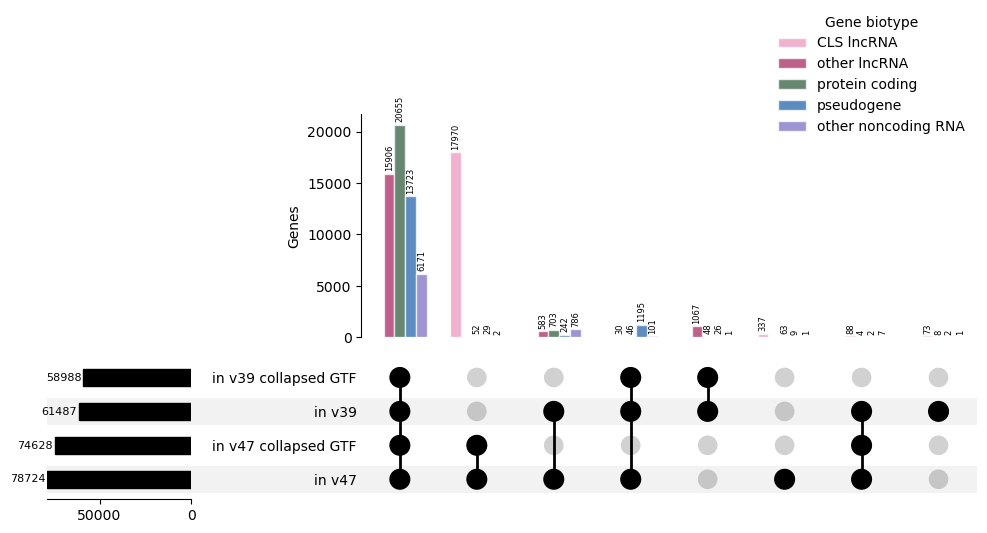

In [92]:
collapse_upset = up.from_indicators(gencode_merged[['in_v47_full', 'in_v47_collapsed', 'in_v39_full','in_v39_collapsed']], data=gencode_merged['gene_type_grouped_highlight'])
collapse_upset.index.set_names(['in v47', 'in v47 collapsed GTF', 'in v39', 'in v39 collapsed GTF'], inplace=True)
collapse_upset = pd.DataFrame(collapse_upset)
collapse_upset_categories = collapse_upset.index.value_counts().index
category_to_idx = {category: idx for idx, category in enumerate(collapse_upset_categories)}
collapse_upset['idx_loc'] = collapse_upset.index.map(category_to_idx)

fig = plt.figure(figsize=(12, 5))
upset = up.UpSet(collapse_upset, show_counts=False, subset_size='count', intersection_plot_elements=6, totals_plot_elements=2, element_size=None, sort_by='cardinality')
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())

totals_ax = plot_result['totals']
totals_ax.grid(False)
# add numbers to plot
for container in totals_ax.containers:
    totals_ax.bar_label(container, padding=1, fontsize=8,)

bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(collapse_upset, x='idx_loc', hue='gene_type_grouped_highlight',ax=bar_ax, palette=gene_type_pal_highlight, hue_order=gene_type_order_highlight, alpha=.7, edgecolor='white', width=.7)
bar_ax.set_ylabel('Genes')
#bar_ax.set_yscale('log')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=2, fontsize=6, rotation=90)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1, 1.5), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

In [87]:
# lost due to collapse
gencode_merged[(gencode_merged['in_v39_collapsed'])&(gencode_merged['in_v47_full'])& ~(gencode_merged['in_v47_collapsed'])]['gene_id_stable'].nunique()

1372

In [88]:
# new genes not in collapse
gencode_merged[~(gencode_merged['in_v39_full']) & (gencode_merged['in_v47_full']) & ~(gencode_merged['in_v47_collapsed'])]['gene_id_stable'].nunique()

410

In [89]:
gencode_merged['collapsed_location_change_v47'] = (gencode_merged['in_v47_collapsed']) & ~(gencode_merged['collapsed_location_match_v47'].astype(bool))
gencode_merged['collapsed_location_change_v39'] = (gencode_merged['in_v39_collapsed']) & ~(gencode_merged['collapsed_location_match_v39'].astype(bool))

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


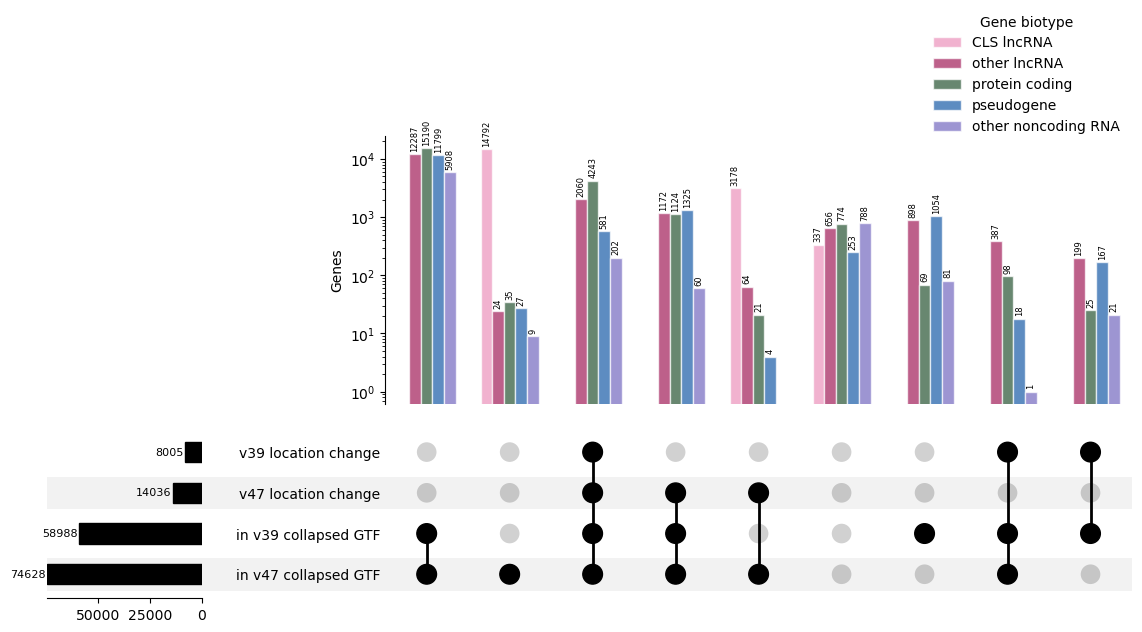

In [95]:
collapse_upset = up.from_indicators(gencode_merged[['in_v47_collapsed', 'collapsed_location_change_v47', 'in_v39_collapsed', 'collapsed_location_change_v39']], data=gencode_merged['gene_type_grouped_highlight'])
collapse_upset.index.set_names(['in v47 collapsed GTF', 'v47 location change', 'in v39 collapsed GTF', 'v39 location change'], inplace=True)
collapse_upset = pd.DataFrame(collapse_upset)
collapse_upset_categories = collapse_upset.index.value_counts().index
category_to_idx = {category: idx for idx, category in enumerate(collapse_upset_categories)}
collapse_upset['idx_loc'] = collapse_upset.index.map(category_to_idx)

fig = plt.figure(figsize=(14, 6))
upset = up.UpSet(collapse_upset, show_counts=False, subset_size='count', intersection_plot_elements=6, totals_plot_elements=2, element_size=None, sort_by='cardinality')
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())

totals_ax = plot_result['totals']
totals_ax.grid(False)
# add numbers to plot
for container in totals_ax.containers:
    totals_ax.bar_label(container, padding=1, fontsize=8,)

bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(collapse_upset, x='idx_loc', hue='gene_type_grouped_highlight',ax=bar_ax, palette=gene_type_pal_highlight, hue_order=gene_type_order_highlight, alpha=.7, edgecolor='white', width=.7)
bar_ax.set_ylabel('Genes')
bar_ax.set_yscale('log')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=2, fontsize=6, rotation=90)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1, 1.5), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

In [94]:
(~(gencode_merged['collapsed_location_change_v39']) & (gencode_merged['collapsed_location_change_v47'])).sum()

6948

In [112]:
gencode_merged['gene_id_v47'] = gencode_merged['gene_id_full_v47']
gencode_merged['gene_id_v39'] = gencode_merged['gene_id_full_v39']
gencode_merged.columns

Index(['Chromosome_collapsed_v47', 'Start_collapsed_v47', 'End_collapsed_v47',
       'gene_id_collapsed_v47', 'gene_id_stable', 'Chromosome_full_v47',
       'Start_full_v47', 'End_full_v47', 'gene_id_full_v47',
       'gene_type_grouped_v47', 'collapsed_location_match_v47',
       'Chromosome_collapsed_v39', 'Start_collapsed_v39', 'End_collapsed_v39',
       'gene_id_collapsed_v39', 'Chromosome_full_v39', 'Start_full_v39',
       'End_full_v39', 'gene_id_full_v39', 'gene_type_grouped_v39',
       'collapsed_location_match_v39', 'gene_type_grouped', 'in_v47_full',
       'in_v47_collapsed', 'in_v39_full', 'in_v39_collapsed',
       'gene_type_grouped_highlight', 'collapsed_location_change_v47',
       'collapsed_location_change_v39', 'gene_id_v47', 'gene_id_v39'],
      dtype='object')

In [114]:
gencode_merged['collapsed_location_change_between_versions'] = (gencode_merged['Start_collapsed_v47'] != gencode_merged['Start_collapsed_v39']) | (gencode_merged['End_collapsed_v47'] != gencode_merged['End_collapsed_v39'])
gencode_merged['full_location_change_between_versions'] = (gencode_merged['Start_full_v47'] != gencode_merged['Start_full_v39']) | (gencode_merged['End_full_v47'] != gencode_merged['End_full_v39'])

In [115]:
gencode_merged[['gene_id_stable', 'gene_id_v47', 'gene_id_v39', 'gene_type_grouped', 'gene_type_grouped_highlight', 'in_v47_full', 'in_v47_collapsed', 'in_v39_full', 'in_v39_collapsed', 'collapsed_location_change_v47', 'collapsed_location_change_v39', 'collapsed_location_change_between_versions', 'full_location_change_between_versions']].to_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching_simplified.txt', sep='\t')

### investigating v39 ids that aren't in v47

1. v39 gene in v47 and quantified
2. v39 gene in v47 but not quantified due to overlap in v47
3. v39 gene in v47 but as a transcript under a different name(s)
4. part of v39 gene (i.e. transcript, exon) in v47 but as a transcript under a different name(s)

In [15]:
# index v39 by gene id
gid_full_gencode_v39 = full_gencode_v39.set_index('gene_id_stable')

# needs to be done in the full gtf becuase the collapsed gtf changes start/end sites to avoid overlap
full_v39 = gid_full_gencode_v39.loc[gencode_v39['gene_id_stable'].unique()].reset_index()

# add in data from v47 to see if the starts/ends match
v47_location_merged = pd.merge(gid_full_gencode_v39, full_gencode_v47[['Chromosome', 'Start', 'End', 'gene_id_stable', 'Feature']], on=['Chromosome', 'Start', 'End'], suffixes=['_v39', '_v47'], how='left')

# group by v39 gene id, see if any of the v47 genes have a matched location 
v47_location_merged_v39_grouped = v47_location_merged.groupby('gene_id_stable_v39').agg({'gene_id_stable_v47':[list, 'unique', 'nunique'], 'Feature_v39':list, 'Feature_v47':list})

# add in flag if the ids match
v47_location_merged_explode = v47_location_merged_v39_grouped.reset_index().explode(('gene_id_stable_v47', 'list'))
v47_location_merged_explode['match'] = v47_location_merged_explode[('gene_id_stable_v47', 'list')] == v47_location_merged_explode['gene_id_stable_v39']
v47_location_merged_id_match = v47_location_merged_explode.groupby('gene_id_stable_v39').agg({('match', ''):'sum'})
v47_location_merged_v39_grouped = v47_location_merged_v39_grouped.join(v47_location_merged_id_match > 0)

KeyError: 'gene_id_stable_v39'

In [ ]:
# add in match levels
# 1 same id same gene
# 2 different id, match in gene
# 3 different id match in transcript
# 4 different id match in exon

no_id_match = v47_location_merged_v39_grouped[~v47_location_merged_v39_grouped['match']]
v47_location_merged_no_id_match = v47_location_merged[v47_location_merged['gene_id_stable_v39'].isin(no_id_match.index.values)]
v47_location_merged_no_id_match_location_match = v47_location_merged_no_id_match[~v47_location_merged_no_id_match['gene_id_stable_v47'].isna()]
v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v39'] == 'gene']['gene_id_stable_v39'].unique()



# 4 different id match in exon
v47_location_merged_v39_grouped['match_idx_v39'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v39'] == 'exon']['gene_id_stable_v39']),
                                                        4, 0)

# 3 different id match in transcript
v47_location_merged_v39_grouped['match_idx_v39'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v39'] == 'transcript']['gene_id_stable_v39']),
                                                        3, v47_location_merged_v39_grouped['match_idx_v39'])
# 2 different id, match in gene
v47_location_merged_v39_grouped['match_idx_v39'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v39'] == 'gene']['gene_id_stable_v39']),
                                                        2, v47_location_merged_v39_grouped['match_idx_v39'])

# 1 same id same gene
v47_location_merged_v39_grouped['match_idx_v39'] = np.where(v47_location_merged_v39_grouped['match'],
                                                            1, v47_location_merged_v39_grouped['match_idx_v39'])




# 4 different id match in exon
v47_location_merged_v39_grouped['match_idx_v47'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v47'] == 'exon']['gene_id_stable_v39']),
                                                        4, 0)

# 3 different id match in transcript
v47_location_merged_v39_grouped['match_idx_v47'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v47'] == 'transcript']['gene_id_stable_v39']),
                                                        3, v47_location_merged_v39_grouped['match_idx_v47'])
# 2 different id, match in gene
v47_location_merged_v39_grouped['match_idx_v47'] = np.where(v47_location_merged_v39_grouped.index.isin(v47_location_merged_no_id_match_location_match[v47_location_merged_no_id_match_location_match['Feature_v47'] == 'gene']['gene_id_stable_v39']),
                                                        2, v47_location_merged_v39_grouped['match_idx_v47'])

# 1 same id same gene
v47_location_merged_v39_grouped['match_idx_v47'] = np.where(v47_location_merged_v39_grouped['match'],
                                                            1, v47_location_merged_v39_grouped['match_idx_v47'])


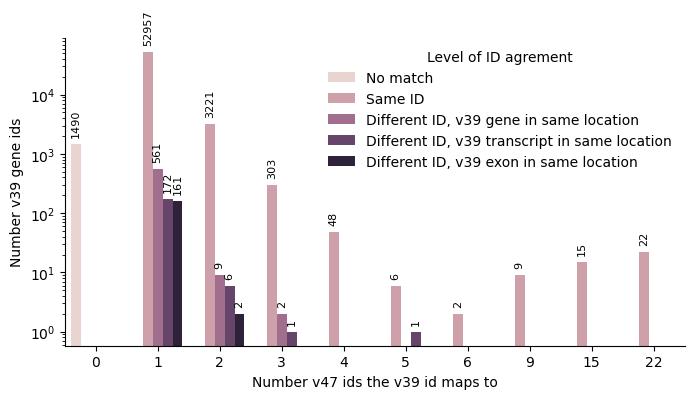

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

sns.countplot(v47_location_merged_v39_grouped, x=('gene_id_stable_v47', 'nunique'), hue='match_idx_v39', ax=ax)
ax.set_yscale('log')
# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=5, fontsize=8, rotation=90)

ax.set_ylabel('Number v39 gene ids')
ax.set_xlabel('Number v47 ids the v39 id maps to')

plt.legend(title='Level of ID agrement', loc='upper right', frameon=False, labels=['No match', 'Same ID', 'Different ID, v39 gene in same location', 'Different ID, v39 transcript in same location', 'Different ID, v39 exon in same location'])

ax.spines[['top', 'right']].set_visible(False)



/local/scratch/klawren/slrmtmp.47796407/ipykernel_56648/888918007.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['No match', 'Same ID', 'Different ID, v47 gene in same location', 'Different ID, v47 transcript in same location', 'Different ID, v47 exon in same location'], rotation=45)


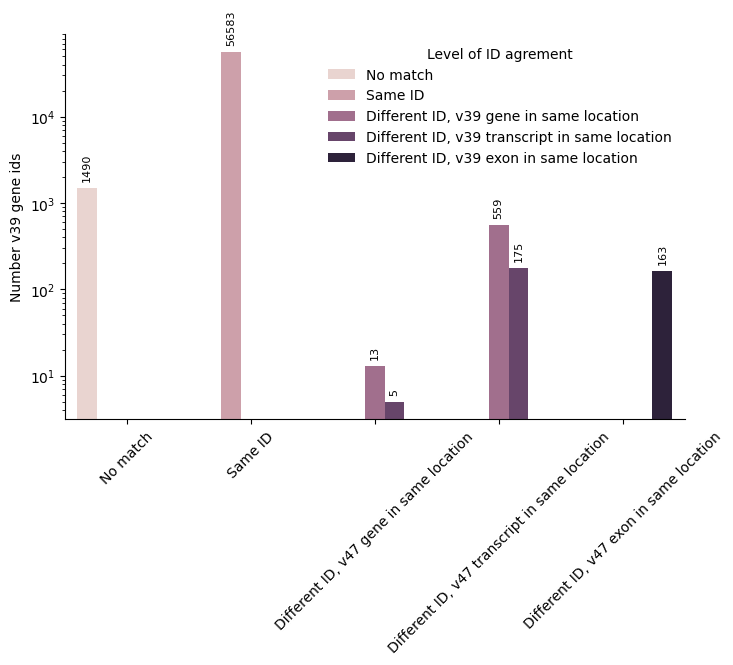

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

sns.countplot(v47_location_merged_v39_grouped, x='match_idx_v47', hue='match_idx_v39', ax=ax)
# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=5, fontsize=8, rotation=90)
ax.set_yscale('log')
ax.spines[['top', 'right']].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Number v39 gene ids')
ax.set_xticklabels(labels=['No match', 'Same ID', 'Different ID, v47 gene in same location', 'Different ID, v47 transcript in same location', 'Different ID, v47 exon in same location'], rotation=45)
plt.legend(title='Level of ID agrement', loc='upper right', frameon=False, labels=['No match', 'Same ID', 'Different ID, v39 gene in same location', 'Different ID, v39 transcript in same location', 'Different ID, v39 exon in same location'])


### and the other way, how many of the v47 are truely not in v39?

In [ ]:
# index v47 by gene id
gid_full_gencode_v47 = full_gencode_v47.set_index('gene_id_stable')

# needs to be done in the full gtf becuase the collapsed gtf changes start/end sites to avoid overlap
full_v47 = gid_full_gencode_v47.loc[gencode_v47['gene_id_stable'].unique()].reset_index()

# add in data from v47 to see if the starts/ends match
v39_location_merged = pd.merge(full_v47, full_gencode_v39[['Chromosome', 'Start', 'End', 'gene_id_stable', 'Feature']], on=['Chromosome', 'Start', 'End'], suffixes=['_v47', '_v39'], how='left')

# group by v39 gene id, see if any of the v47 genes have a matched location 
v39_location_merged_v47_grouped = v39_location_merged.groupby('gene_id_stable_v47').agg({'gene_id_stable_v39':[list, 'unique', 'nunique'], 'Feature_v39':list, 'Feature_v47':list})

# add in flag if the ids match
v39_location_merged_explode = v39_location_merged_v47_grouped.reset_index().explode(('gene_id_stable_v39', 'list'))
v39_location_merged_explode['match'] = v39_location_merged_explode[('gene_id_stable_v39', 'list')] == v39_location_merged_explode['gene_id_stable_v47']
v39_location_merged_id_match = v39_location_merged_explode.groupby('gene_id_stable_v47').agg({('match', ''):'sum'})
v39_location_merged_v47_grouped = v39_location_merged_v47_grouped.join(v39_location_merged_id_match > 0)

In [ ]:
# add in match levels
# 1 same id same gene
# 2 different id, match in gene
# 3 different id match in transcript
# 4 different id match in exon

no_id_match = v39_location_merged_v47_grouped[~v39_location_merged_v47_grouped['match']]
v39_location_merged_no_id_match = v39_location_merged[v39_location_merged['gene_id_stable_v47'].isin(no_id_match.index.values)]
v39_location_merged_no_id_match_location_match = v39_location_merged_no_id_match[~v39_location_merged_no_id_match['gene_id_stable_v39'].isna()]
v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v47'] == 'gene']['gene_id_stable_v47'].unique()

# 1 same id same gene
v39_location_merged_v47_grouped['match_idx_v39'] = np.where(v39_location_merged_v47_grouped['match'], 1, 0)

# 4 different id match in exon
v39_location_merged_v47_grouped['match_idx_v39'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v39'] == 'exon']['gene_id_stable_v47']),
                                                        4, v39_location_merged_v47_grouped['match_idx_v39'])

# 3 different id match in transcript
v39_location_merged_v47_grouped['match_idx_v39'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v39'] == 'transcript']['gene_id_stable_v47']),
                                                        3, v39_location_merged_v47_grouped['match_idx_v39'])
# 2 different id, match in gene
v39_location_merged_v47_grouped['match_idx_v39'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v39'] == 'gene']['gene_id_stable_v47']),
                                                        2, v39_location_merged_v47_grouped['match_idx_v39'])



# 1 same id same gene
v39_location_merged_v47_grouped['match_idx_v47'] = np.where(v39_location_merged_v47_grouped['match'], 1, 0)

# 4 different id match in exon
v39_location_merged_v47_grouped['match_idx_v47'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v47'] == 'exon']['gene_id_stable_v47']),
                                                        4, v39_location_merged_v47_grouped['match_idx_v47'])

# 3 different id match in transcript
v39_location_merged_v47_grouped['match_idx_v47'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v47'] == 'transcript']['gene_id_stable_v47']),
                                                        3, v39_location_merged_v47_grouped['match_idx_v47'])
# 2 different id, match in gene
v39_location_merged_v47_grouped['match_idx_v47'] = np.where(v39_location_merged_v47_grouped.index.isin(v39_location_merged_no_id_match_location_match[v39_location_merged_no_id_match_location_match['Feature_v47'] == 'gene']['gene_id_stable_v47']),
                                                        2, v39_location_merged_v47_grouped['match_idx_v47'])



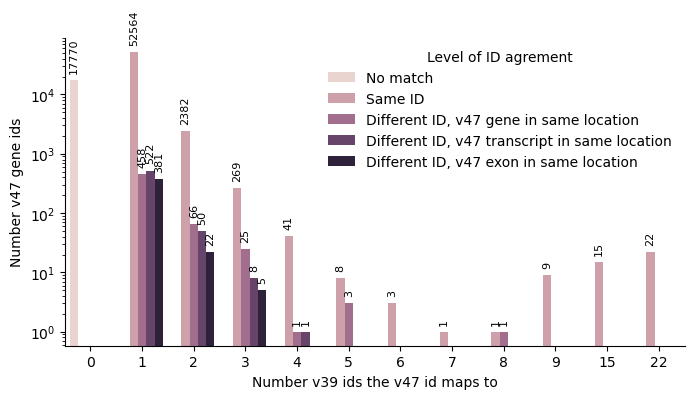

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

sns.countplot(v39_location_merged_v47_grouped, x=('gene_id_stable_v39', 'nunique'), hue='match_idx_v39', ax=ax)
ax.set_yscale('log')
# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=5, fontsize=8, rotation=90)

ax.set_ylabel('Number v47 gene ids')
ax.set_xlabel('Number v39 ids the v47 id maps to')

plt.legend(title='Level of ID agrement', loc='upper right', frameon=False, labels=['No match', 'Same ID', 'Different ID, v47 gene in same location', 'Different ID, v47 transcript in same location', 'Different ID, v47 exon in same location'])

ax.spines[['top', 'right']].set_visible(False)



/local/scratch/klawren/slrmtmp.47796407/ipykernel_56648/3733613344.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['No match', 'Same ID', 'Different ID, v39 gene in same location', 'Different ID, v39 transcript in same location', 'Different ID, v39 exon in same location'], rotation=45)


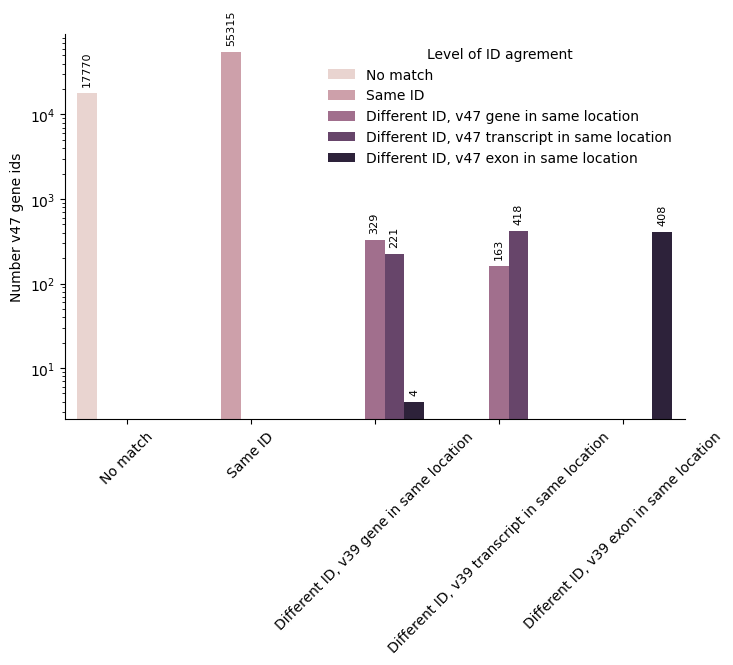

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

sns.countplot(v39_location_merged_v47_grouped, x='match_idx_v39', hue='match_idx_v47', ax=ax)
# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=5, fontsize=8, rotation=90)
ax.set_yscale('log')
ax.spines[['top', 'right']].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Number v47 gene ids')
ax.set_xticklabels(labels=['No match', 'Same ID', 'Different ID, v39 gene in same location', 'Different ID, v39 transcript in same location', 'Different ID, v39 exon in same location'], rotation=45)
plt.legend(title='Level of ID agrement', loc='upper right', frameon=False, labels=['No match', 'Same ID', 'Different ID, v47 gene in same location', 'Different ID, v47 transcript in same location', 'Different ID, v47 exon in same location'])


In [ ]:
full_gencode_v39[full_gencode_v39['gene_id_stable'] == v39_location_merged_v47_grouped[v39_location_merged_v47_grouped[('gene_id_stable_v39', 'nunique')] > 20].index.values[0]]


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid,gene_id_stable,gene_type_harmonized,gene_type_grouped
941789,chr5,HAVANA,gene,141338759,141512975,.,+,.,ENSG00000081853.15,protein_coding,...,overlapping_locus,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000081853,protein_coding,protien_coding
941790,chr5,HAVANA,transcript,141338759,141343302,.,+,.,ENSG00000081853.15,protein_coding,...,basic,OTTHUMT00000377024.2,NaN,NaN,NaN,ENSP00000483020.1,NaN,ENSG00000081853,protein_coding,protien_coding
941791,chr5,HAVANA,exon,141338759,141343302,.,+,.,ENSG00000081853.15,protein_coding,...,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853,protein_coding,protien_coding
941792,chr5,HAVANA,CDS,141338971,141341440,.,+,0,ENSG00000081853.15,protein_coding,...,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853,protein_coding,protien_coding
941793,chr5,HAVANA,start_codon,141338971,141338974,.,+,0,ENSG00000081853.15,protein_coding,...,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853,protein_coding,protien_coding
941794,chr5,HAVANA,stop_codon,141341440,141341443,.,+,0,ENSG00000081853.15,protein_coding,...,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853,protein_coding,protien_coding
941795,chr5,HAVANA,UTR,141338759,141338971,.,+,.,ENSG00000081853.15,protein_coding,...,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853,protein_coding,protien_coding
941796,chr5,HAVANA,UTR,141341440,141343302,.,+,.,ENSG00000081853.15,protein_coding,...,basic,OTTHUMT00000377024.2,1,ENSE00002198097.2,NaN,ENSP00000483020.1,NaN,ENSG00000081853,protein_coding,protien_coding
941797,chr5,HAVANA,transcript,141338759,141512975,.,+,.,ENSG00000081853.15,protein_coding,...,CCDS,OTTHUMT00000374738.2,NaN,NaN,NaN,ENSP00000378077.2,CCDS47289.1,ENSG00000081853,protein_coding,protien_coding
941798,chr5,HAVANA,exon,141338759,141341395,.,+,.,ENSG00000081853.15,protein_coding,...,CCDS,OTTHUMT00000374738.2,1,ENSE00001161295.7,NaN,ENSP00000378077.2,CCDS47289.1,ENSG00000081853,protein_coding,protien_coding


### output with summaries of how gene ids are shared

* full_match, (collapsed gtf location the same)
* full_match_different_collapse (same location in full gtf, but collapsed differently)
* id_match_location_change (different location in full gtf)
* id_change_locaiton_match (different id, match at gene/transcript/exon level)
* v39_only (no match even at exon level)
* v47_only (no match even at exon level)

and then another column for if its quantified in v39 and v47 or not due to overlap
* in collapsed v39
* in collaped v47

In [ ]:
# get list of all gene ids in either
id_mapping = pd.merge(full_gencode_v39.drop_duplicates(['gene_id', 'gene_id_stable'])[['gene_id', 'gene_id_stable', 'gene_type_harmonized']], full_gencode_v47.drop_duplicates(['gene_id', 'gene_id_stable'])[['gene_id', 'gene_id_stable', 'gene_type']], on='gene_id_stable', suffixes=['_v39', '_v47'], how='outer')

# are they quantified in the collapsed gtf?
id_mapping['in_collapsed_v39'] = id_mapping['gene_id_v39'].isin(gencode_v39['gene_id'])
id_mapping['in_collapsed_v47'] = id_mapping['gene_id_v47'].isin(gencode_v47['gene_id'])

In [ ]:
# what level of match? 
id_mapping['match_level'] = 'None'

# same location in collapsed gtf
collapsed_merge = pd.merge(gencode_v39, gencode_v47, on='gene_id_stable', how='outer', suffixes=['_v39', '_v47'])
full_match_in_collapsed = collapsed_merge[(collapsed_merge['Chromosome_v39'] == collapsed_merge['Chromosome_v47'])&(collapsed_merge['Start_v39'] == collapsed_merge['Start_v47'])&(collapsed_merge['End_v39'] == collapsed_merge['End_v47'])]['gene_id_stable']
id_mapping['match_level'] = np.where(id_mapping['gene_id_stable'].isin(full_match_in_collapsed), 'full_match', id_mapping['match_level'])
id_mapping['match_level'].value_counts()

match_level
full_match    44243
None          35753
Name: count, dtype: int64

In [ ]:
# same location in full gtf
# drop duplicated for v39 removes y paralogs
full_merge = pd.merge(full_gencode_v39[full_gencode_v39['Feature'] == 'gene'].drop_duplicates('gene_id_stable'), full_gencode_v47[full_gencode_v47['Feature'] == 'gene'], on='gene_id_stable', how='inner', suffixes=['_v39', '_v47'])
full_match_in_full = full_merge[(full_merge['Chromosome_v39'] == full_merge['Chromosome_v47'])&(full_merge['Start_v39'] == full_merge['Start_v47'])&(full_merge['End_v39'] == full_merge['End_v47'])]['gene_id_stable']
id_mapping['match_level'] = np.where(~(id_mapping['gene_id_stable'].isin(full_match_in_collapsed)) & id_mapping['gene_id_stable'].isin(full_match_in_full), 'id_match_different_collapse_location', id_mapping['match_level'])
id_mapping['match_level'].value_counts()

match_level
full_match                              44243
None                                    29957
id_match_different_collapse_location     5796
Name: count, dtype: int64

In [ ]:
# same id, but different location in full gtf
no_match_in_full = full_merge[~full_merge['gene_id_stable'].isin(full_match_in_full)]['gene_id_stable']
id_mapping['match_level'] = np.where(id_mapping['gene_id_stable'].isin(no_match_in_full), 'id_match_different_location', id_mapping['match_level'])
id_mapping['match_level'].value_counts()

match_level
full_match                              44015
None                                    19691
id_match_different_location             10494
id_match_different_collapse_location     5796
Name: count, dtype: int64

In [ ]:
# the location merged from above are only for transcripts in the collapsed gtf, which these are not
# create new location merged with all genes 
# check if they match location in one vs the other
all_genes_location_merged = pd.merge(full_gencode_v47, full_gencode_v39[['Chromosome', 'Start', 'End', 'gene_id_stable', 'Feature']], on=['Chromosome', 'Start', 'End'], suffixes=['_v47', '_v39'], how='outer')
all_genes_location_merged_v47_grouped = all_genes_location_merged.groupby('gene_id_stable_v47').agg({'gene_id_stable_v39':'nunique'})
all_genes_location_merged_v39_grouped = all_genes_location_merged.groupby('gene_id_stable_v39').agg({'gene_id_stable_v47':'nunique'})

In [ ]:
location_match_v39_ids = all_genes_location_merged_v39_grouped[all_genes_location_merged_v39_grouped['gene_id_stable_v47']>0].index.values
location_match_v47_ids = all_genes_location_merged_v47_grouped[all_genes_location_merged_v47_grouped['gene_id_stable_v39']>0].index.values
locaiton_match_ids = np.concatenate([location_match_v39_ids, location_match_v47_ids])
id_mapping['match_level'] = np.where(~(id_mapping['gene_id_stable'].isin(full_merge['gene_id_stable'])) & (id_mapping['gene_id_stable'].isin(locaiton_match_ids)), 'location_match_different_id', id_mapping['match_level'])
id_mapping['match_level'].value_counts()

match_level
full_match                              44015
None                                    17085
id_match_different_location             10494
id_match_different_collapse_location     5796
location_match_different_id              2606
Name: count, dtype: int64

In [ ]:
unique_v47_ids = all_genes_location_merged_v47_grouped[all_genes_location_merged_v47_grouped['gene_id_stable_v39']==0].index.values
id_mapping['match_level'] = np.where(~(id_mapping['gene_id_stable'].isin(full_merge['gene_id_stable'])) & (id_mapping['gene_id_stable'].isin(unique_v47_ids)), 'unique_v47', id_mapping['match_level'])
id_mapping['match_level'].value_counts()

match_level
full_match                              44015
unique_v47                              16828
id_match_different_location             10494
id_match_different_collapse_location     5796
location_match_different_id              2606
None                                      257
Name: count, dtype: int64

In [ ]:
unique_v39_ids = all_genes_location_merged_v39_grouped[all_genes_location_merged_v39_grouped['gene_id_stable_v47']==0].index.values
id_mapping['match_level'] = np.where(~(id_mapping['gene_id_stable'].isin(full_merge['gene_id_stable'])) & (id_mapping['gene_id_stable'].isin(unique_v39_ids)), 'unique_v39', id_mapping['match_level'])
id_mapping['match_level'].value_counts()

match_level
full_match                              44015
unique_v47                              16828
id_match_different_location             10494
id_match_different_collapse_location     5796
location_match_different_id              2606
unique_v39                                257
Name: count, dtype: int64

In [ ]:
# ensure v47 gene types are the ones that are recorded
id_mapping['gene_type'] = np.where(id_mapping['gene_type'].isna(), id_mapping['gene_type_harmonized'], id_mapping['gene_type'])
id_mapping['gene_type_harmonized'] = id_mapping['gene_type']
group_gene_type(id_mapping)
id_mapping = id_mapping.drop(columns='gene_type_harmonized')

id_mapping = id_mapping.drop_duplicates('gene_id_stable')
id_mapping['in_collapsed'] = np.where((id_mapping['in_collapsed_v47']) & ~(id_mapping['gene_id_v47'].isna()), 
                                      np.where((id_mapping['in_collapsed_v39']) & ~(id_mapping['gene_id_v47'].isna()), 'both', 'v47 only'), 
                                      np.where((id_mapping['in_collapsed_v39']) & ~(id_mapping['gene_id_v39'].isna()), 'v39 only', 'neither'))

# write out
id_mapping.to_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', index=None, sep='\t')

In [ ]:
id_mapping = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')

/local/scratch/klawren/slrmtmp.47798853/ipykernel_2169/2444499537.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  id_mapping = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode_id_matching.txt', sep='\t')


/local/scratch/klawren/slrmtmp.47798853/ipykernel_2169/3638437515.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=['ID in both, location match', 'ID in both,\n location mismatch in collapsed GTF', 'ID in both,\n location mismatch in full GTF', 'Location in both,\ndifferent ID', 'Location and ID only in v39', 'Location and ID only in v47'])


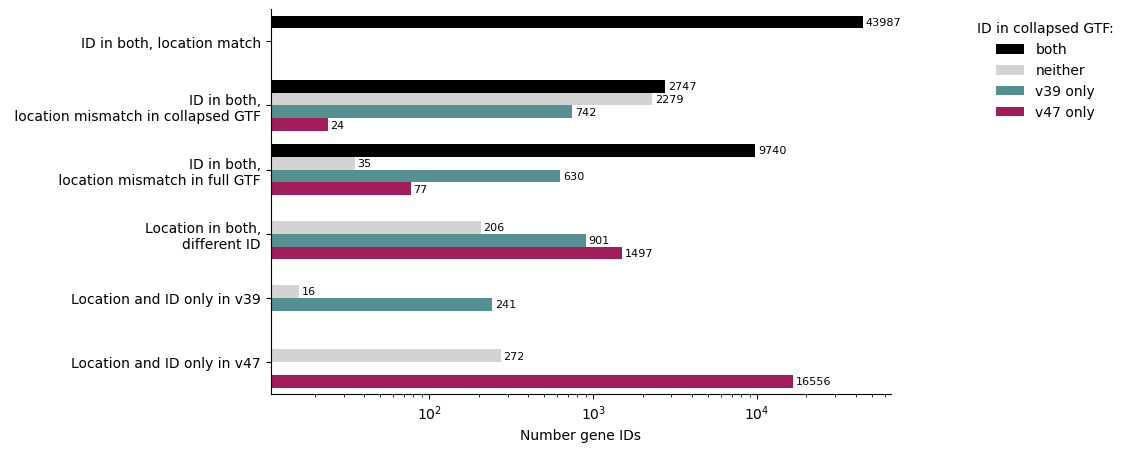

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

sns.countplot(id_mapping, y='match_level', hue='in_collapsed', ax=ax, palette=['black', 'lightgrey', '#4a989c', '#b70657'], 
              order=['full_match', 'id_match_different_collapse_location', 'id_match_different_location', 'location_match_different_id', 'unique_v39', 'unique_v47'])
# add numbers to plot
for container in ax.containers:
    ax.bar_label(container, padding=2, fontsize=8)
ax.set_xscale('log')
ax.spines[['top', 'right']].set_visible(False)

ax.set_ylabel('')
ax.set_xlabel('Number gene IDs')
ax.set_yticklabels(labels=['ID in both, location match', 'ID in both,\n location mismatch in collapsed GTF', 'ID in both,\n location mismatch in full GTF', 'Location in both,\ndifferent ID', 'Location and ID only in v39', 'Location and ID only in v47'])
plt.legend(title='ID in collapsed GTF:', loc='upper center', frameon=False, bbox_to_anchor=(1.25, 1))

